<a href="https://colab.research.google.com/github/allenz0935/NCHU-MIS/blob/main/%E7%BE%85%E5%81%89%E5%80%AB_week9%E4%BD%9C%E6%A5%AD_%E9%80%80%E7%81%AB%E5%9F%BA%E5%9B%A0%E7%89%B9%E5%BE%B5%E7%AF%A9%E9%81%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#第9週作業：特徵篩選 - 基因演算法 vs 模擬退火
# 使用LSTM模型進行股票價格預測

###【核心目標】
###透過進化演算法自動找出最佳特徵組合，提升股票價格預測模型的性能
###【為什麼需要特徵篩選？】
1. 不是所有特徵都有用：有些技術指標可能包含重複資訊或雜訊
2. 減少過擬合風險：過多特徵會讓模型記住訓練資料的雜訊
3. 提高計算效率：更少的特徵意味著更快的訓練速度
4. 提升模型泛化能力：只保留真正有價值的特徵

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random
import math
import warnings
import os
warnings.filterwarnings('ignore')

In [2]:
# ============================================================================
# 初始設定
# ============================================================================
print("="*80)
print("第9週作業：智能特徵篩選 - 基因演算法 vs 模擬退火")
print("="*80)

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用設備: {device}")

OUTPUT_DIR = './outputs/'
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"輸出目錄: {OUTPUT_DIR}\n")

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (14, 6)

第9週作業：智能特徵篩選 - 基因演算法 vs 模擬退火
使用設備: cuda
輸出目錄: ./outputs/



## 資料收集與特徵工程

In [3]:
# ============================================================================
# [Part 1/6] 資料收集與特徵工程
# ============================================================================
print("="*80)
print("[Part 1/6] 資料收集與特徵工程")
print("="*80)

ticker = "AAPL"
start_date = "2020-01-01"
end_date = "2024-12-31"

stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)

# 處理可能的 MultiIndex (yfinance 有時會返回 MultiIndex DataFrame)
if isinstance(stock_data.columns, pd.MultiIndex):
    stock_data.columns = stock_data.columns.get_level_values(0)

print(f"下載 {ticker} 資料：{start_date} 至 {end_date}")
print(f"原始資料形狀：{stock_data.shape}")

# 【為什麼需要這麼多技術指標？】
# 目的：讓GA和SA自動找出哪些指標真正有用
# 設計理念：
# 1. 刻意加入多樣化的指標（趨勢、動量、波動度、成交量）
# 2. 包含一些「看似有用但實際無用」的特徵（如星期幾、雜訊）
# 3. 讓演算法通過實驗學習哪些特徵真正有價值
# 模擬真實情況：我們通常不確定哪些特徵最有效。
print("\n計算技術指標...")

# ========================================
# 類別 1：趨勢指標
# ========================================
stock_data['SMA_5'] = stock_data['Close'].rolling(window=5).mean()
stock_data['SMA_10'] = stock_data['Close'].rolling(window=10).mean()
stock_data['SMA_20'] = stock_data['Close'].rolling(window=20).mean()
stock_data['EMA_12'] = stock_data['Close'].ewm(span=12, adjust=False).mean()
stock_data['EMA_26'] = stock_data['Close'].ewm(span=26, adjust=False).mean()

ema_12 = stock_data['Close'].ewm(span=12, adjust=False).mean()
ema_26 = stock_data['Close'].ewm(span=26, adjust=False).mean()
stock_data['MACD'] = ema_12 - ema_26
stock_data['MACD_SIGNAL'] = stock_data['MACD'].ewm(span=9, adjust=False).mean()
stock_data['MACD_HIST'] = stock_data['MACD'] - stock_data['MACD_SIGNAL']

# ========================================
# 類別 2：動量震盪指標
# ========================================
delta = stock_data['Close'].diff()
gain = delta.mask(delta < 0, 0)
loss = -delta.mask(delta > 0, 0)
avg_gain = gain.ewm(com=13, min_periods=14).mean()
avg_loss = loss.ewm(com=13, min_periods=14).mean()
rs = avg_gain / avg_loss
stock_data['RSI_14'] = 100 - (100 / (1 + rs))

low_14 = stock_data['Low'].rolling(window=14).min()
high_14 = stock_data['High'].rolling(window=14).max()
stock_data['STOCH_K'] = 100 * ((stock_data['Close'] - low_14) / (high_14 - low_14))
stock_data['STOCH_D'] = stock_data['STOCH_K'].rolling(window=3).mean()

stock_data['ROC'] = ((stock_data['Close'] - stock_data['Close'].shift(12)) /
                     stock_data['Close'].shift(12)) * 100

tp = (stock_data['High'] + stock_data['Low'] + stock_data['Close']) / 3.0
sma_tp_20 = tp.rolling(20).mean()
mean_dev_20 = (tp - sma_tp_20).abs().rolling(20).mean()
stock_data['CCI_20'] = (tp - sma_tp_20) / (0.015 * (mean_dev_20 + 1e-8))

# ========================================
# 類別 3：波動度指標
# ========================================
bb_mid = stock_data['Close'].rolling(20).mean()
if isinstance(bb_mid, pd.DataFrame): bb_mid = bb_mid.iloc[:, 0]
bb_std = stock_data['Close'].rolling(20).std()
if isinstance(bb_std, pd.DataFrame): bb_std = bb_std.iloc[:, 0]

stock_data['BB_MID_20'] = bb_mid.astype(float)
stock_data['BB_UP_20'] = (bb_mid + 2 * bb_std).astype(float)
stock_data['BB_LOW_20'] = (bb_mid - 2 * bb_std).astype(float)
bb_width_20 = (stock_data['BB_UP_20'] - stock_data['BB_LOW_20']) / (bb_mid + 1e-8)
if isinstance(bb_width_20, pd.DataFrame): bb_width_20 = bb_width_20.iloc[:, 0]
stock_data['BB_WIDTH_20'] = bb_width_20.astype(float)

hl = stock_data['High'] - stock_data['Low']
hc = (stock_data['High'] - stock_data['Close'].shift(1)).abs()
lc = (stock_data['Low'] - stock_data['Close'].shift(1)).abs()
tr = pd.concat([hl, hc, lc], axis=1).max(axis=1)
stock_data['ATR_14'] = tr.rolling(window=14, min_periods=14).mean()

log_ret = np.log(stock_data['Close'] / stock_data['Close'].shift(1))
stock_data['HV_30'] = log_ret.rolling(30).std() * np.sqrt(252)

hl_range = (stock_data['High'] - stock_data['Low']).abs()
ema_hl_10 = hl_range.ewm(span=10, adjust=False).mean()
stock_data['ChaikinVol_10'] = 100.0 * (ema_hl_10 - ema_hl_10.shift(10)) / (ema_hl_10.shift(10) + 1e-8)

# ========================================
# 類別 4：成交量指標
# ========================================
price_diff = stock_data['Close'].diff()
volume_direction = np.where(price_diff > 0, stock_data['Volume'],
                            np.where(price_diff < 0, -stock_data['Volume'], 0))
stock_data['OBV'] = volume_direction.cumsum()

vwap_num = (tp * stock_data['Volume']).cumsum()
vwap_den = stock_data['Volume'].cumsum()
stock_data['VWAP'] = vwap_num / (vwap_den + 1e-8)

vol_ma_s = stock_data['Volume'].rolling(14).mean()
vol_ma_l = stock_data['Volume'].rolling(28).mean()
stock_data['VolOsc'] = 100 * (vol_ma_s - vol_ma_l) / (vol_ma_l + 1e-8)

# ========================================
# 測試用特徵（包含無用/有害特徵）
# ========================================
# 這些特徵看起來合理，但實際對預測幫助不大
# 需要通過實驗發現這些特徵的價值

## 時間特徵（對股價預測通常無效）
# 為什麼時間特徵無效？股市沒有"星期一必漲"這種規律
stock_data['WEEKDAY_ENC'] = stock_data.index.dayofweek.astype(float) # 週幾 (0-6)
stock_data['MONTH_ENC'] = stock_data.index.month.astype(float) # 月份 (1-12)
## 加入雜訊的特徵（直接使用當前數據長度）
stock_data['NOISE_VOL'] = stock_data['Volume'].astype(float) + np.random.randn(len(stock_data)) * 1000

# ========================================
# 創建目標變數
# ========================================
# 為什麼用shift(-1)？我們要預測明天的收盤價，所以目標是未來一天的價格
stock_data['Target'] = stock_data['Close'].shift(-1)
stock_data = stock_data.dropna()

# 收集所有特徵名稱（排除原始OHLCV和目標變數）
ALL_FEATURES = [col for col in stock_data.columns if col not in
                ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Target']]
print(f"總特徵數: {len(ALL_FEATURES)}")
print(f"特徵列表前10個: {ALL_FEATURES[:10]}")

[Part 1/6] 資料收集與特徵工程
下載 AAPL 資料：2020-01-01 至 2024-12-31
原始資料形狀：(1257, 5)

計算技術指標...
總特徵數: 26
特徵列表前10個: ['SMA_5', 'SMA_10', 'SMA_20', 'EMA_12', 'EMA_26', 'MACD', 'MACD_SIGNAL', 'MACD_HIST', 'RSI_14', 'STOCH_K']


## 資料分割與預處理

In [4]:

# ============================================================================
# [Part 2/6] 資料分割與預處理
# ============================================================================
print("\n" + "="*80)
print("[Part 2/6] 資料分割與預處理")
print("="*80)

train_size = int(len(stock_data) * 0.7)
val_size = int(len(stock_data) * 0.15)

train_data = stock_data[:train_size]
val_data = stock_data[train_size:train_size + val_size]
test_data = stock_data[train_size + val_size:]

X_train = train_data[ALL_FEATURES]
y_train = train_data['Target']
X_val = val_data[ALL_FEATURES]
y_val = val_data['Target']
X_test = test_data[ALL_FEATURES]
y_test = test_data['Target']

print(f"訓練集: {len(X_train)} 筆")
print(f"驗證集: {len(X_val)} 筆")
print(f"測試集: {len(X_test)} 筆")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# ========================================
# 創建時間序列
# ========================================
# 【為什麼需要lookback？】
# LSTM需要「一段時間的歷史資料」來預測未來
#
# 【如何運作】
# lookback = 10 表示用過去10天的資料預測明天
#
# 舉例：
# 輸入：[第1-10天的特徵] → 輸出：第11天的價格
# 輸入：[第2-11天的特徵] → 輸出：第12天的價格
# ...
#
# 【資料形狀變化】
# 原始：(樣本數, 特徵數)
# 轉換後：(樣本數-lookback, lookback, 特徵數)
#         = (批次, 時間步, 特徵)

lookback_period = 10

def create_sequences(X, y, lookback):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i+lookback])
        ys.append(y[i+lookback])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, lookback_period)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val.values, lookback_period)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, lookback_period)

print(f"\n時間序列形狀:")
print(f"  訓練集: {X_train_seq.shape}")
print(f"  驗證集: {X_val_seq.shape}")
print(f"  測試集: {X_test_seq.shape}")




[Part 2/6] 資料分割與預處理
訓練集: 852 筆
驗證集: 182 筆
測試集: 184 筆

時間序列形狀:
  訓練集: (842, 10, 26)
  驗證集: (172, 10, 26)
  測試集: (174, 10, 26)


## 模型定義

In [5]:
# ============================================================================
# [Part 3/6] 模型定義
# ============================================================================
print("\n" + "="*80)
print("[Part 3/6] 模型定義")
print("="*80)

import torch
import torch.nn as nn

class LSTMRegressor(nn.Module):
    """
    LSTM股價預測模型

    【架構說明】
    Input → LSTM層 → Dropout → 全連接層 → Output

    【為什麼用LSTM？】
    1. 能記住長期依賴關係（Long Short-Term Memory）
    2. 避免梯度消失問題（相比傳統RNN）
    3. 適合時間序列預測

    【架構細節】
    1. LSTM層：
       - 學習時間序列模式
       - hidden_dim控制記憶容量（越大越複雜）
       - num_layers控制深度（多層可學習更複雜模式）

    2. Dropout層：
       - 隨機關閉部分神經元
       - 防止過擬合

    3. 全連接層：
       - 將LSTM輸出映射到預測值
       - 使用ReLU激活函數增加非線性
    """
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, dropout=0.2, output_dim=1):
        """
        初始化模型

        參數說明：
        - input_dim: 輸入特徵數量（由選擇的特徵決定）
        - hidden_dim: LSTM隱藏層大小
          * 越大：學習能力越強，但計算成本高、容易過擬合
          * 越小：訓練快，但表達能力受限
          * 建議：64-256之間

        - num_layers: LSTM層數
          * 1層：簡單模式
          * 2-3層：複雜模式（推薦）
          * >3層：容易過擬合

        - dropout: Dropout比例
          * 0.1-0.3：常用範圍
          * 太高：模型欠擬合
          * 太低：容易過擬合

        - output_dim: 輸出維度（預測明天的收盤價，所以是1）
        """

        super(LSTMRegressor, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        # 為什麼用batch_first=True？讓資料格式為[批次, 時間, 特徵]，更直觀
        # LSTM 主體
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )

        # 全連接輸出層
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim//2, output_dim)
        )

    def forward(self, x):
        """
        前向傳播過程

        【如何運作】
        1. 初始化隱藏狀態（h0, c0）為零向量
        2. LSTM處理整個序列，更新隱藏狀態
        3. 取最後時間步的輸出（包含所有歷史資訊的總結）
        4. 通過全連接層得到最終預測值

        【為什麼只用最後時間步？】
        - 最後時間步的輸出已包含整個序列的資訊
        - LSTM的設計理念：將變長序列編碼成固定長度向量

        參數：
        - x: 輸入張量，形狀 (batch_size, seq_len, features)

        返回：
        - out: 預測值，形狀 (batch_size, 1)
        """

        # x: (batch, seq_len, features)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # 取最後時間步
        return out

print("LSTM模型定義完成")

def train_model(model, train_loader, val_loader, epochs=30, lr=1e-3, verbose=False):
    """
    訓練LSTM模型

    【為什麼這樣設計訓練流程？】
    1. Adam優化器：自適應學習率，收斂更快更穩定
    2. MSE損失函數：適合回歸問題（最小化預測誤差平方和）
    3. Early Stopping：防止過擬合，節省訓練時間

    【訓練流程】
    For each epoch:
        1. 訓練模式：
           - 遍歷所有批次
           - 計算損失
           - 反向傳播
           - 更新權重

        2. 驗證模式：
           - 關閉Dropout和BatchNorm
           - 計算驗證損失
           - 不更新權重

        3. Early Stopping檢查：
           - 如果驗證損失改善：重置patience計數器
           - 如果驗證損失未改善：增加計數器
           - 如果連續patience個epoch未改善：停止訓練

    參數說明：
    - model: 要訓練的模型
    - train_loader: 訓練資料載入器
    - val_loader: 驗證資料載入器
    - epochs: 最大訓練輪數
    - lr: 學習率（Learning Rate）
      * 太大：訓練不穩定，可能發散
      * 太小：收斂太慢
      * 建議：1e-3到1e-4
    - verbose: 是否顯示訓練過程

    返回：
    - model: 訓練好的模型
    """
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_loss = float('inf')
    # Early Stopping參數
    patience, patience_counter = 10, 0

    for ep in range(epochs):
        model.train()
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(Xb)
            loss = criterion(out.squeeze(), yb)
            loss.backward()
            optimizer.step()

        model.eval() # 設為評估模式（關閉Dropout）
        val_loss = 0
        # 為什麼用torch.no_grad？驗證時不需要計算梯度，節省記憶體和時間
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                val_loss += criterion(model(Xb).squeeze(), yb).item()
        val_loss /= len(val_loader)

        # ========================================
        # Early Stopping邏輯
        # ========================================
        # 為什麼需要Early Stopping？
        # 當驗證損失停止改善時，繼續訓練會導致：
        # 1. 訓練損失繼續下降（記住訓練資料）
        # 2. 驗證損失開始上升（泛化能力變差）
        # 3. 浪費時間和計算資源
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                if verbose: print(f"  Early stopping at epoch {ep+1}")
                break

        if verbose and (ep+1) % 10 == 0:
            print(f"  Epoch {ep+1}/{epochs} - Val Loss: {val_loss:.6f}")

    return model

def evaluate_model(model, X_test, y_test):
    """
    評估模型性能

    【為什麼用RMSE和MAE？】

    1. RMSE（Root Mean Squared Error）均方根誤差
       公式：√(Σ(預測-實際)² / n)
       特點：
       - 對大誤差更敏感（因為有平方項）
       - 單位與目標變數相同（如：美元）
       - 適合評估極端情況的影響

    2. MAE（Mean Absolute Error）平均絕對誤差
       公式：Σ|預測-實際| / n
       特點：
       - 對所有誤差平等對待
       - 更穩健（不受異常值影響）
       - 更容易解釋

    【何時用哪個？】
    - RMSE：關注極端錯誤時（如風險管理）
    - MAE：關注平均表現時（如日常預測）
    - 同時報告：最全面

    參數：
    - model: 訓練好的模型
    - X_test: 測試特徵
    - y_test: 測試目標

    返回：
    - rmse: 均方根誤差
    - mae: 平均絕對誤差
    """
    model.eval()
    with torch.no_grad():
        preds = model(torch.Tensor(X_test).to(device)).cpu().squeeze().numpy()
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    return rmse, mae


[Part 3/6] 模型定義
LSTM模型定義完成


## Baseline (全特徵)

In [6]:
# ============================================================================
# [Part 4/6] 階段1 - Baseline (全特徵)
# ============================================================================
print("\n" + "="*80)
print("[Part 4/6] 階段1 - Baseline (全特徵)")
print("="*80)

# ========================================
# 【為什麼需要Baseline？】
# ========================================
# 目的：建立比較基準
#
# 如果GA/SA的結果比Baseline還差，那就失敗了
# 如果GA/SA的結果更好，才證明特徵篩選有效
#
# Baseline策略：使用所有特徵（不做篩選）

# ========================================
# 創建DataLoader
# ========================================
# 【為什麼使用DataLoader？】
#
# 優點：
# 1. 自動批次處理
#    - 一次處理batch_size個樣本
#    - 充分利用GPU並行計算能力
#
# 2. 自動打亂訓練資料（shuffle=True）
#    - 防止模型記住資料順序
#    - 每個epoch都有不同的批次組合
#    - 提升泛化能力
#
# 3. 簡化程式碼
#    - 不用手動管理批次索引
#    - 自動處理最後不足一個批次的資料
#
# 【batch_size的選擇】
# - 太大（如256）：記憶體需求高，泛化能力可能變差
# - 太小（如8）：訓練不穩定，速度慢
# - 建議：32-64（在計算效率和泛化之間平衡）

train_loader_full = DataLoader(
    TensorDataset(torch.Tensor(X_train_seq), torch.Tensor(y_train_seq)),
    batch_size=32, shuffle=True
)
val_loader_full = DataLoader(
    TensorDataset(torch.Tensor(X_val_seq), torch.Tensor(y_val_seq)),
    batch_size=32
)

print("\n訓練 LSTM-Baseline...")
trans_baseline = LSTMRegressor(len(ALL_FEATURES)).to(device)
trans_baseline = train_model(trans_baseline, train_loader_full, val_loader_full, epochs=50, verbose=True)
rmse_trans_base, mae_trans_base = evaluate_model(trans_baseline, X_test_seq, y_test_seq)
print(f"LSTM-Baseline RMSE: {rmse_trans_base:.6f}, MAE: {mae_trans_base:.6f}")


[Part 4/6] 階段1 - Baseline (全特徵)

訓練 LSTM-Baseline...
  Epoch 10/50 - Val Loss: 1980.607463
  Early stopping at epoch 17
LSTM-Baseline RMSE: 85.396458, MAE: 82.982639


## 基因演算法 & 模擬退火

In [7]:
# ============================================================================
# 特徵子集評估函數
# ============================================================================
def evaluate_feature_subset(features, model_class, n_trials=3, epochs=20, verbose=False):
    """
    評估特定特徵子集的效能

    【為什麼需要這個函數？】
    這是GA和SA的核心評估函數（適應度函數）

    【如何運作】
    1. 接收一組特徵
    2. 用這些特徵訓練模型
    3. 在驗證集上評估
    4. 返回RMSE（越小越好）

    【為什麼要多次試驗（n_trials）？】
    原因：神經網路訓練有隨機性
    - 權重初始化是隨機的
    - Dropout是隨機的
    - 資料打亂是隨機的

    解決方案：
    - 訓練n_trials次，取平均
    - 減少偶然性的影響
    - 得到更可靠的評估

    參數：
    - features: 特徵名稱列表
    - model_class: 模型類別（LSTMRegressor）
    - n_trials: 評估次數（減少隨機性）
    - epochs: 訓練輪數（不需要太多，因為只是評估）
    - verbose: 是否顯示詳細資訊

    返回：
    - mean_rmse: 平均RMSE
    - std_rmse: RMSE的標準差（衡量穩定性）
    """
    # 為什麼至少要有一個特徵 --> 沒有特徵無法訓練模型
    if len(features) == 0:
        return np.inf, 0 # 返回無窮大，表示這是糟糕的解

    # ========================================
    # 提取選中的特徵
    # ========================================
    # 根據特徵名稱找到對應的列索引
    f_idx = [ALL_FEATURES.index(f) for f in features]
    Xtr = X_train_scaled[:, f_idx]
    Xva = X_val_scaled[:, f_idx]
    # 創建時間序列
    Xtr_seq, ytr_seq = create_sequences(Xtr, y_train.values, lookback_period)
    Xva_seq, yva_seq = create_sequences(Xva, y_val.values, lookback_period)
    # 創建DataLoader
    tr_loader = DataLoader(
        TensorDataset(torch.Tensor(Xtr_seq), torch.Tensor(ytr_seq)),
        batch_size=32, shuffle=True
    )
    va_loader = DataLoader(
        TensorDataset(torch.Tensor(Xva_seq), torch.Tensor(yva_seq)),
        batch_size=32
    )
    # 多次試驗
    scores = []
    for trial in range(n_trials):
        # 設定不同的隨機種子
        # 為什麼？確保每次試驗的初始化不同，但整體可重現
        torch.manual_seed(SEED + trial)
        np.random.seed(SEED + trial)
        # 創建並訓練模型
        model = model_class(len(features)).to(device)
        model = train_model(model, tr_loader, va_loader, epochs=epochs, verbose=False)
        # 評估
        rmse, _ = evaluate_model(model, Xva_seq, yva_seq)
        scores.append(rmse)

        if verbose:
            print(f"    Trial {trial+1}/{n_trials}: RMSE = {rmse:.6f}")

    mean_rmse = np.mean(scores)
    std_rmse = np.std(scores)

    return mean_rmse, std_rmse

# ============================================================================
# 修改區域：實驗參數設定
# ============================================================================
#
# 作業說明：
# 請修改以下參數，進行不同的實驗，觀察參數如何影響結果
#
# 實驗建議：
# 1. 固定其他參數，只改變一個參數（例如：世代數）
# 2. 記錄每組實驗的結果（RMSE、特徵數、運行時間）
# 3. 分析參數對結果的影響
#
# ============================================================================

# --------------------------------------------
# 基因演算法 (GA) 參數
# --------------------------------------------
# TODO: 修改以下參數進行實驗

ga_generations = 15         # 世代數（建議範圍: 10-25）
                            # 越多：收斂越好，但時間越長
                            # 越少：速度快，但可能收斂不足
                            # 建議：先用10試試，如果結果還在改善就增加

ga_pop_size = 40           # 族群大小（建議範圍: 15-30）
                           # 越大：搜索空間大，多樣性好，不易早熟
                           # 越小：速度快，但容易困在局部最優
                           # 建議：特徵數越多，族群就要越大

ga_mutation_rate = 0.25    # 變異率（建議範圍: 0.1-0.25）
                           # 越高：探索性強，多樣性好，但不穩定
                           # 越低：收斂快，但可能困在局部最優

# --------------------------------------------
# 模擬退火 (SA) 參數
# --------------------------------------------
# TODO: 修改以下參數進行實驗

sa_T_init = 100             # 初始溫度（建議範圍: 30-100）
                           # 越高：接受劣解機率大，探索性強
                           # 越低：較快收斂到局部最優

sa_cooling_rate = 0.90     # 冷卻率（建議範圍: 0.80-0.95）
                           # 越高：降溫慢，搜索細緻，但時間長
                           # 越低：降溫快，收斂快但可能不夠好

sa_T_min = 1               # 最低溫度（建議保持在1）
                      # 溫度降到這個值就停止

# --------------------------------------------
# 通用參數
# --------------------------------------------
n_trials = 3               # 每個特徵組合評估次數（建議保持在3）
                      # 用於減少隨機性影響
                      # 太多會很慢，太少結果不穩定

epochs_inner = 40          # GA/SA內部評估時的訓練輪數


epochs_final = 50          # 最終測試集評估的訓練輪數
                     # 與baseline保持一致

# ============================================================================
# 修改區域結束
# ============================================================================

print("\n" + "="*80)
print("實驗參數設定")
print("="*80)
print(f"GA參數: 世代數={ga_generations}, 族群大小={ga_pop_size}, 變異率={ga_mutation_rate}")
print(f"SA參數: 初始溫度={sa_T_init}, 冷卻率={sa_cooling_rate}")
print(f"評估參數: 每個組合評估{n_trials}次, 內部訓練{epochs_inner}輪")
print("="*80)

# ============================================================================
# [Part 5/6] 階段2 & 3 - 基因演算法 & 模擬退火
# ============================================================================
print("\n" + "="*80)
print("[Part 5/6] 階段2 & 3 - 進化演算法特徵篩選")
print("="*80)

# ========================================
# 基因演算法
# ========================================
def genetic_algorithm(model_class, model_name, generations, pop_size,
                     mutation_rate, n_trials, verbose=True):
    """基因演算法特徵選擇"""
    """
    基因演算法特徵選擇

    【演算法靈感】
    模擬生物進化過程：
    1. 自然選擇：適者生存
    2. 基因交叉：父母特徵混合產生後代
    3. 突變：隨機變異保持多樣性

    【如何運作】

    ┌─────────────────────────────────────────┐
    │ 1. 初始化族群                                 │
    │    隨機生成pop_size個染色體                         │
    │    每個染色體 = [1,0,1,0,...]（特徵選擇）                 │
    └─────────────────────────────────────────┘
                    ↓
    ┌─────────────────────────────────────────┐
    │ 2. 評估適應度                                 │
    │    對每個個體訓練模型，計算RMSE                       │
    │    RMSE越小 = 適應度越高
    └─────────────────────────────────────────┘
                    ↓
    ┌─────────────────────────────────────────┐
    │ 3. 選擇（Selection）                              │
    │    保留表現最好的一半個體作為父母                      │
    │    淘汰表現差的個體                             │
    └─────────────────────────────────────────┘
                    ↓
    ┌─────────────────────────────────────────┐
    │ 4. 交叉（Crossover）                              │
    │    隨機配對兩個父母                             │
    │    在隨機位置切割染色體                           │
    │    前半來自父親，後半來自母親                        │
    │                                         │
    │    父親: [1,1,0,0,1,1]                           │
    │    母親: [0,1,1,1,0,0]                           │
    │         切割點↑                            │
    │    後代: [1,1,0|1,0,0]                           │
    └─────────────────────────────────────────┘
                    ↓
    ┌─────────────────────────────────────────┐
    │ 5. 突變（Mutation）                              │
    │    以mutation_rate的機率翻轉每個基因
    │    [1,1,0,1,0,0] → [1,0,0,1,0,0]                     │
    │           ↑翻轉                           │
    │    目的：避免早熟收斂、保持多樣性                      │
    └─────────────────────────────────────────┘
                    ↓
    ┌─────────────────────────────────────────┐
    │ 6. 重複2-5直到達到世代數                           │
    └─────────────────────────────────────────┘

    【為什麼有效】
    - 好的特徵組合會被保留和傳播
    - 壞的特徵組合會被淘汰
    - 交叉和突變產生新的組合
    - 經過多代進化，族群整體越來越好

    參數：
    - model_class: 模型類別
    - model_name: 模型名稱（用於顯示）
    - generations: 進化世代數
    - pop_size: 族群大小
    - mutation_rate: 變異率
    - n_trials: 評估時的試驗次數
    - verbose: 是否顯示詳細過程

    返回：
    - best_features: 最佳特徵列表
    - history: 進化歷史記錄
    """

    print(f"\n{'='*60}")
    print(f"基因演算法 - {model_name}")
    print(f"{'='*60}")
    print(f"參數設定: 世代數={generations}, 族群大小={pop_size}, 變異率={mutation_rate}")

    # ========================================
    # 1. 初始化族群
    # ========================================
    # 【染色體編碼】
    # 每個個體是一個二進位陣列，長度 = 特徵數
    # [1, 0, 1, 1, 0, ...] 表示選擇第1、3、4個特徵
    #
    # 為什麼用隨機初始化？
    # - 保證多樣性
    # - 覆蓋整個搜索空間

    population = [np.random.choice([0, 1], len(ALL_FEATURES)) for _ in range(pop_size)]
    # 記錄進化歷史
    history = {
        'best_scores': [], # 每代最佳分數
        'mean_scores': [], # 每代平均分數
        'worst_scores': [], # 每代最差分數
        'best_features': [], # 每代最佳特徵組合
        'best_n_features': [] # 每代最佳特徵數量
    }

    best_individual = None
    best_score = float('inf')

    # ========================================
    # 2. 進化主循環
    # ========================================
    for gen in range(generations):
        print(f"\n第 {gen+1}/{generations} 代:")

        # ========================================
        # 2.1 評估適應度
        # ========================================
        scored_population = []
        for idx, individual in enumerate(population):
            # 解碼：將染色體轉換為特徵列表
            selected_features = [f for i, f in enumerate(ALL_FEATURES) if individual[i] == 1]
            # 評估這組特徵的性能
            if len(selected_features) == 0:
                score = np.inf # 沒有特徵 = 最差
                std = 0
            else:
                score, std = evaluate_feature_subset(selected_features, model_class, n_trials=n_trials, epochs=epochs_inner)

            scored_population.append((score, std, individual, selected_features))

            if verbose and (idx + 1) % 5 == 0:
                print(f"  評估進度: {idx+1}/{pop_size} (當前RMSE: {score:.6f}±{std:.4f}, 特徵數: {len(selected_features)})")
        # 按分數排序
        scored_population.sort(key=lambda x: x[0])

        # ========================================
        # 2.2 記錄統計資訊
        # ========================================
        scores = [s[0] for s in scored_population if s[0] != np.inf]
        if len(scores) > 0:
            history['best_scores'].append(scored_population[0][0])
            history['mean_scores'].append(np.mean(scores))
            history['worst_scores'].append(scored_population[-1][0])
            history['best_features'].append(scored_population[0][3])
            history['best_n_features'].append(len(scored_population[0][3]))

            print(f"  最佳RMSE: {scored_population[0][0]:.6f}±{scored_population[0][1]:.4f} (特徵數: {len(scored_population[0][3])})")
            print(f"  平均RMSE: {np.mean(scores):.6f}")
            print(f"  最差RMSE: {scored_population[-1][0]:.6f}")
        # 更新全局最佳
        if scored_population[0][0] < best_score:
            best_score = scored_population[0][0]
            best_individual = scored_population[0][2].copy()
            print(f"  發現新的最佳解！RMSE = {best_score:.6f}")


        # ========================================
        # 2.3 選擇（Selection）
        # ========================================
        # 【選擇策略】
        # 1. 精英保留（Elitism）：直接保留最好的20%
        #    - 確保好的解不會丟失
        # 2. 剩餘80%由父母交叉產生
        #    - 保持多樣性
        n_parents = pop_size // 2 # 前50%作為父母
        parents = [ind for _, _, ind, _ in scored_population[:n_parents]]

        n_elite = pop_size // 5 # 保留前20%
        new_population = [scored_population[i][2].copy() for i in range(n_elite)]

        # ========================================
        # 2.4 交叉（Crossover）+ 突變（Mutation）
        # ========================================
        while len(new_population) < pop_size:
            # 隨機選擇兩個父母
            parent1, parent2 = random.sample(parents, 2)
            # ========================================
            # 單點交叉（Single-Point Crossover）
            # ========================================
            # 【如何運作】
            # 1. 隨機選擇切割點
            # 2. 前半來自parent1，後半來自parent2
            #
            # 例如：
            # parent1: [1, 1, 0, | 0, 1, 1]
            # parent2: [0, 1, 1, | 1, 0, 0]
            #            ↑ 切割點
            # child:   [1, 1, 0, | 1, 0, 0]

            crossover_point = random.randint(1, len(ALL_FEATURES) - 1)
            child = np.concatenate([parent1[:crossover_point], parent2[crossover_point:]])
            # ========================================
            # 突變（Mutation）
            # ========================================
            # 【如何運作】
            # 以mutation_rate的機率翻轉每個基因
            #
            # 【為什麼需要突變】
            # 1. 保持多樣性
            # 2. 避免早熟收斂（整個族群變得太相似）
            # 3. 探索新的特徵組合
            for i in range(len(child)):
                if random.random() < mutation_rate:
                    child[i] = 1 - child[i] # 0變1，1變0

            new_population.append(child)
        # 更新族群
        population = new_population
    # ========================================
    # 3. 返回最佳解
    # ========================================
    best_features = [f for i, f in enumerate(ALL_FEATURES) if best_individual[i] == 1]

    print(f"\n{'='*60}")
    print(f"基因演算法完成！")
    print(f"最佳RMSE: {best_score:.6f}")
    print(f"選出特徵數: {len(best_features)}")
    print(f"{'='*60}")

    return best_features, history

# ========================================
# 模擬退火
# ========================================
def simulated_annealing(model_class, model_name, T_init, cooling_rate,
                       T_min, n_trials, verbose=True):
    """
    模擬退火特徵選擇

    【演算法靈感】
    模擬金屬退火過程：
    1. 高溫：原子活躍，可以移動到任何位置
    2. 慢慢降溫：原子逐漸穩定
    3. 低溫：原子固定在能量最低的位置

    【如何運作】

    ┌─────────────────────────────────────────┐
    │ 1. 初始化                                   │
    │    隨機選擇一組特徵                             │
    │    設定初始溫度T = T_init                         │
    └─────────────────────────────────────────┘
                    ↓
    ┌─────────────────────────────────────────┐
    │ 2. 產生鄰居解                                 │
    │    隨機翻轉一個特徵的選擇狀態                        │
    │    當前: [1,0,1,1,0]                            │
    │    鄰居: [1,1,1,1,0]  ←第2個特徵翻轉                   │
    └─────────────────────────────────────────┘
                    ↓
    ┌─────────────────────────────────────────┐
    │ 3. 計算適應度變化                               │
    │    Δ = 鄰居的RMSE - 當前的RMSE                     │
    └─────────────────────────────────────────┘
                    ↓
          ┌─────────┴─────────┐
          │                   │
       Δ < 0                  Δ ≥ 0
       (變好)                     (變差)
          │                   │
          ↓                   ↓
    ┌──────────┐      ┌──────────────────┐
    │必定接受      │      │以機率P接受:            │
    │          │      │P = exp(-Δ/T)          │
    │          │      │                  │
    │          │      │溫度高→P大→易接受         │
    │          │      │溫度低→P小→難接受         │
    └──────────┘      └──────────────────┘
          │                   │
          └─────────┬─────────┘
                    ↓
    ┌─────────────────────────────────────────┐
    │ 4. 降溫                                    │
    │    T = T * cooling_rate                         │
    │    (例如：T = T * 0.85)                         │
    └─────────────────────────────────────────┘
                    ↓
    ┌─────────────────────────────────────────┐
    │ 5. 重複2-4直到T < T_min                           │
    └─────────────────────────────────────────┘

    【核心機制：接受機率】

    P(接受) = exp(-Δ/T)

    當Δ=10（鄰居差10單位）：
    - T=100: P=exp(-10/100)=0.90 → 很可能接受
    - T=50:  P=exp(-10/50)=0.82  → 可能接受
    - T=10:  P=exp(-10/10)=0.37  → 不太接受
    - T=1:   P=exp(-10/1)=0.00   → 幾乎不接受

    【為什麼有效】
    1. 高溫階段：
       - 大膽探索，接受劣解
       - 跳出局部最優

    2. 中溫階段：
       - 謹慎探索
       - 偶爾接受劣解

    3. 低溫階段：
       - 只接受好解
       - 收斂到最優

    【與GA的區別】
    - GA：族群並行搜索（多個解同時進化）
    - SA：單一解逐步改進（更節省記憶體）

    參數：
    - model_class: 模型類別
    - model_name: 模型名稱
    - T_init: 初始溫度（控制探索程度）
    - cooling_rate: 冷卻率（控制降溫速度）
    - T_min: 最低溫度（停止條件）
    - n_trials: 評估時的試驗次數
    - verbose: 是否顯示詳細過程

    返回：
    - best_features: 最佳特徵列表
    - history: 搜索歷史記錄
    """
    print(f"\n{'='*60}")
    print(f"模擬退火 - {model_name}")
    print(f"{'='*60}")
    print(f"參數設定: 初始溫度={T_init}, 冷卻率={cooling_rate}, 最低溫度={T_min}")

    # ========================================
    # 1. 初始化
    # ========================================
    # 隨機生成初始解
    current_solution = np.random.choice([0, 1], len(ALL_FEATURES))
    current_features = [f for i, f in enumerate(ALL_FEATURES) if current_solution[i] == 1]
    current_score, current_std = evaluate_feature_subset(current_features, model_class, n_trials=n_trials, epochs=epochs_inner)
    # 記錄全局最佳
    best_solution = current_solution.copy()
    best_score = current_score
    best_features = current_features.copy()
    # 記錄搜索歷史
    history = {
        'temperatures': [],# 溫度變化
        'current_scores': [], # 當前解的分數
        'best_scores': [], # 最佳解的分數
        'n_features': [], # 特徵數量
        'acceptance_count': 0, # 接受次數
        'total_iterations': 0 # 總迭代次數
    }

    T = T_init
    iteration = 0

    print(f"\n初始解: RMSE = {current_score:.6f}±{current_std:.4f} (特徵數: {len(current_features)})")

    # ========================================
    # 2. 退火主循環
    # ========================================
    while T > T_min:
        iteration += 1
        history['total_iterations'] = iteration

        # ========================================
        # 2.1 產生鄰居解
        # ========================================
        # 【鄰域定義】
        # 翻轉一個特徵的選擇狀態
        #
        # 為什麼只翻轉一個？
        # - 保證鄰居解與當前解相似
        # - 逐步搜索，而非隨機跳躍

        neighbor = current_solution.copy()
        flip_idx = random.randint(0, len(ALL_FEATURES) - 1)
        neighbor[flip_idx] = 1 - neighbor[flip_idx]
        # 解碼鄰居
        neighbor_features = [f for i, f in enumerate(ALL_FEATURES) if neighbor[i] == 1]
        # 評估鄰居
        if len(neighbor_features) == 0:
            neighbor_score = np.inf
            neighbor_std = 0
        else:
            neighbor_score, neighbor_std = evaluate_feature_subset(neighbor_features, model_class, n_trials=n_trials, epochs=epochs_inner)

        # ========================================
        # 2.2 決定是否接受鄰居
        # ========================================
        delta = neighbor_score - current_score

        if delta < 0:
          # 鄰居更好 → 必定接受
            accept = True
        else:
            # 鄰居更差 → 以機率接受
            # 【Metropolis準則】
            # P(接受) = exp(-Δ/T)
            #
            # 為什麼要接受劣解？
            # 1. 跳出局部最優
            # 2. 探索更多可能性
            # 3. 溫度越高，接受機率越大
            acceptance_prob = np.exp(-delta / T)
            accept = random.random() < acceptance_prob
        # 接受鄰居
        if accept:
            current_solution = neighbor
            current_score = neighbor_score
            current_std = neighbor_std
            current_features = neighbor_features
            history['acceptance_count'] += 1
            # 更新全局最佳
            if current_score < best_score:
                best_score = current_score
                best_solution = current_solution.copy()
                best_features = current_features.copy()
                print(f"  迭代 {iteration}: 發現新的最佳解！RMSE = {best_score:.6f}±{current_std:.4f} (特徵數: {len(best_features)})")
        # ========================================
        # 2.3 記錄歷史
        # ========================================
        history['temperatures'].append(T)
        history['current_scores'].append(current_score)
        history['best_scores'].append(best_score)
        history['n_features'].append(len(current_features))

        if verbose and iteration % 10 == 0:
            acc_rate = history['acceptance_count'] / iteration * 100
            print(f"  迭代 {iteration}: T={T:.2f}, 當前RMSE={current_score:.6f}, "
                  f"最佳RMSE={best_score:.6f}, 接受率={acc_rate:.1f}%")
        # ========================================
        # 2.4 降溫
        # ========================================
        # 【冷卻策略：指數衰減】
        # T = T * cooling_rate
        #
        # 例如：cooling_rate=0.85
        # T = 100 → 85 → 72.25 → 61.41 → ...
        #
        # 為什麼用指數衰減？
        # - 開始降溫慢（充分探索）
        # - 後期降溫快（加速收斂）
        T *= cooling_rate

    print(f"\n{'='*60}")
    print(f"模擬退火完成！")
    print(f"總迭代次數: {iteration}")
    print(f"接受率: {history['acceptance_count']/iteration*100:.1f}%")
    print(f"最佳RMSE: {best_score:.6f}")
    print(f"選出特徵數: {len(best_features)}")
    print(f"{'='*60}")

    return best_features, history

# ========================================
# 執行特徵篩選
# ========================================
print("\n開始執行特徵篩選...")

# GA-LSTM
ga_trans_features, ga_trans_history = genetic_algorithm(
    LSTMRegressor, "LSTM",
    generations=ga_generations,
    pop_size=ga_pop_size,
    mutation_rate=ga_mutation_rate,
    n_trials=n_trials
)

# SA-LSTM
sa_trans_features, sa_trans_history = simulated_annealing(
    LSTMRegressor, "LSTM",
    T_init=sa_T_init,
    cooling_rate=sa_cooling_rate,
    T_min=sa_T_min,
    n_trials=n_trials
)


實驗參數設定
GA參數: 世代數=15, 族群大小=40, 變異率=0.25
SA參數: 初始溫度=100, 冷卻率=0.9
評估參數: 每個組合評估3次, 內部訓練40輪

[Part 5/6] 階段2 & 3 - 進化演算法特徵篩選

開始執行特徵篩選...

基因演算法 - LSTM
參數設定: 世代數=15, 族群大小=40, 變異率=0.25

第 1/15 代:
  評估進度: 5/40 (當前RMSE: 33.535736±18.2681, 特徵數: 15)
  評估進度: 10/40 (當前RMSE: 45.591551±0.2524, 特徵數: 12)
  評估進度: 15/40 (當前RMSE: 22.057058±17.3876, 特徵數: 15)
  評估進度: 20/40 (當前RMSE: 46.282592±0.5262, 特徵數: 9)
  評估進度: 25/40 (當前RMSE: 8.253313±0.3818, 特徵數: 17)
  評估進度: 30/40 (當前RMSE: 7.374973±0.4651, 特徵數: 18)
  評估進度: 35/40 (當前RMSE: 21.155654±18.0283, 特徵數: 15)
  評估進度: 40/40 (當前RMSE: 21.108497±17.2276, 特徵數: 12)
  最佳RMSE: 7.374973±0.4651 (特徵數: 18)
  平均RMSE: 28.607730
  最差RMSE: 46.376081
  發現新的最佳解！RMSE = 7.374973

第 2/15 代:
  評估進度: 5/40 (當前RMSE: 9.159946±0.8261, 特徵數: 18)
  評估進度: 10/40 (當前RMSE: 46.035219±0.3009, 特徵數: 9)
  評估進度: 15/40 (當前RMSE: 46.183103±0.6178, 特徵數: 16)
  評估進度: 20/40 (當前RMSE: 7.366219±1.6137, 特徵數: 14)
  評估進度: 25/40 (當前RMSE: 9.322318±1.3062, 特徵數: 17)
  評估進度: 30/40 (當前RMSE: 22.435248±17.0931, 特徵數: 15)
 

## 測試集評估


最終測試集評估

🔹 評估 GA-LSTM...
  Epoch 10/50 - Val Loss: 872.512167
  Epoch 20/50 - Val Loss: 879.927576
  Epoch 30/50 - Val Loss: 61.166494
  Epoch 40/50 - Val Loss: 25.759543
  Epoch 50/50 - Val Loss: 16.829200
GA-LSTM - RMSE: 39.992653, MAE: 36.127406

🔹 評估 SA-LSTM...
  Epoch 10/50 - Val Loss: 875.919235
  Early stopping at epoch 17
SA-LSTM - RMSE: 86.551731, MAE: 84.168145

[Part 6/6] 結果分析與可視化

性能比較結果
       Method  N_Features      RMSE       MAE  RMSE_Improvement
LSTM-Baseline          26 85.396458 82.982639          0.000000
      LSTM-GA          14 39.992653 36.127406         53.168253
      LSTM-SA          16 86.551731 84.168145         -1.352835

結果已保存至: ./outputs/results_comparison.csv

生成可視化圖表...


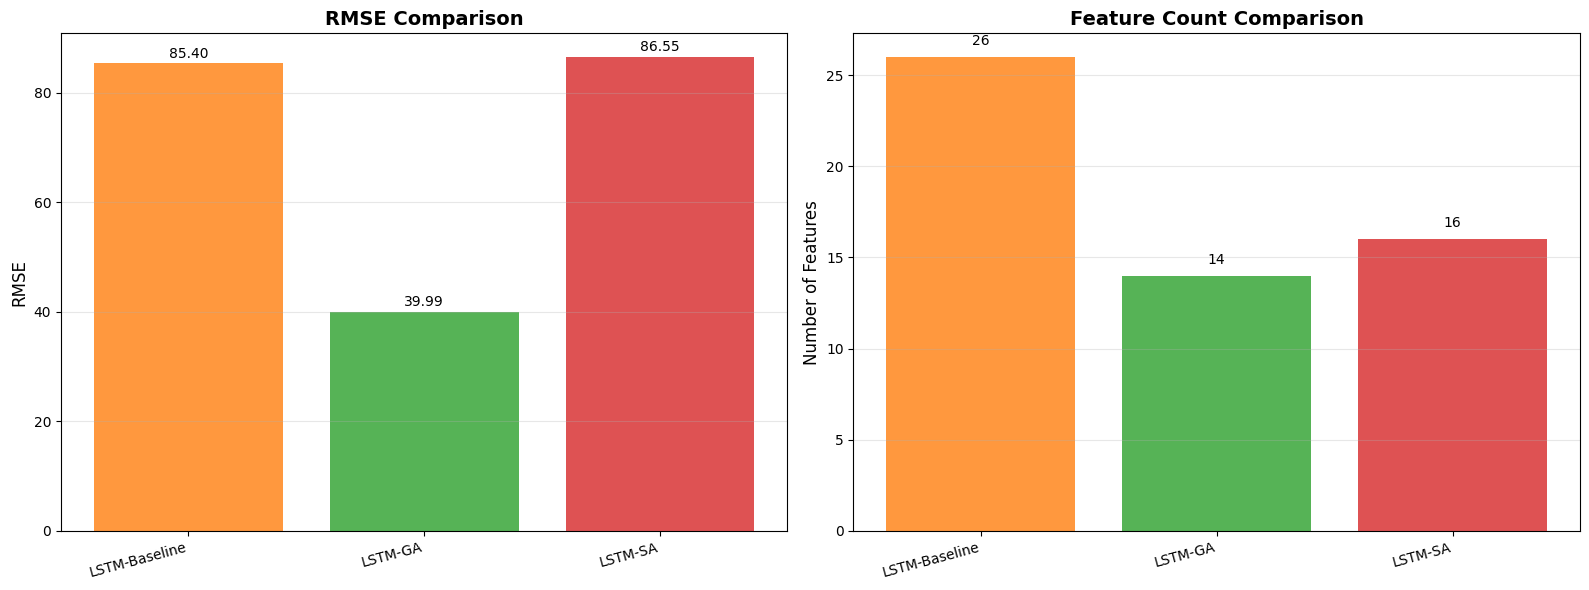

圖1: 性能對比柱狀圖


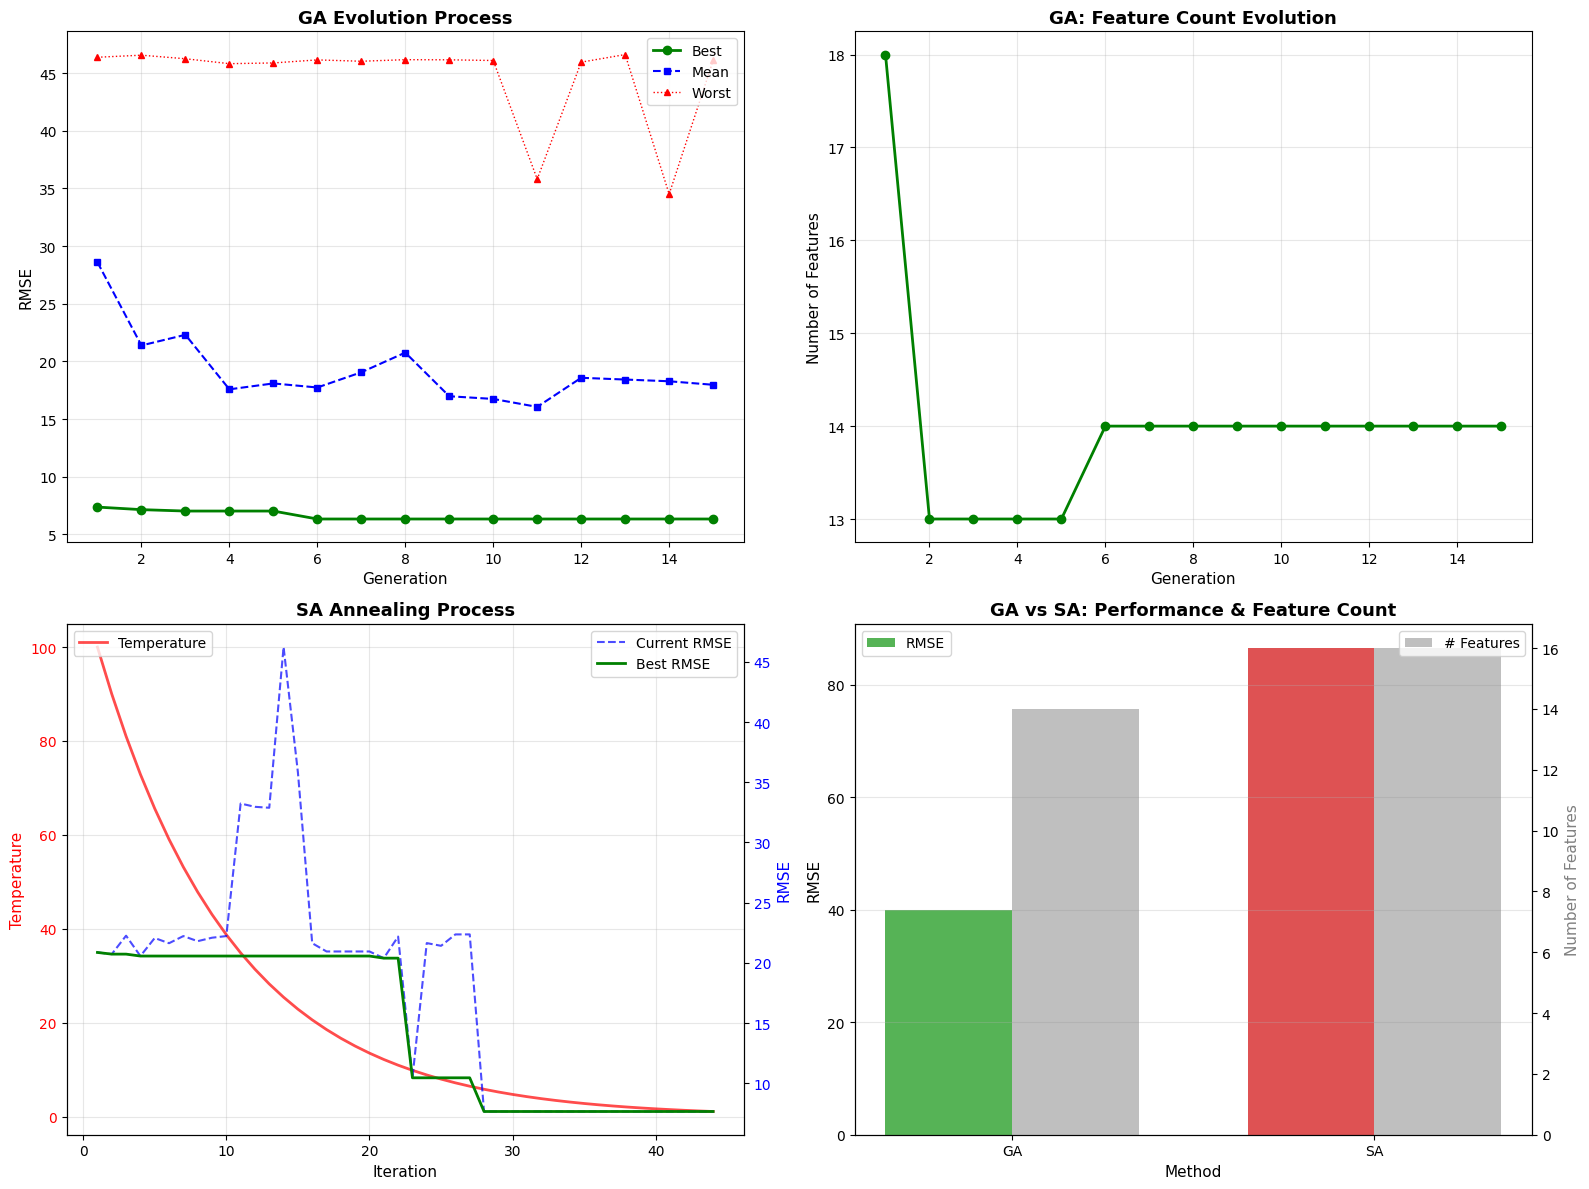

圖2: 演化過程分析


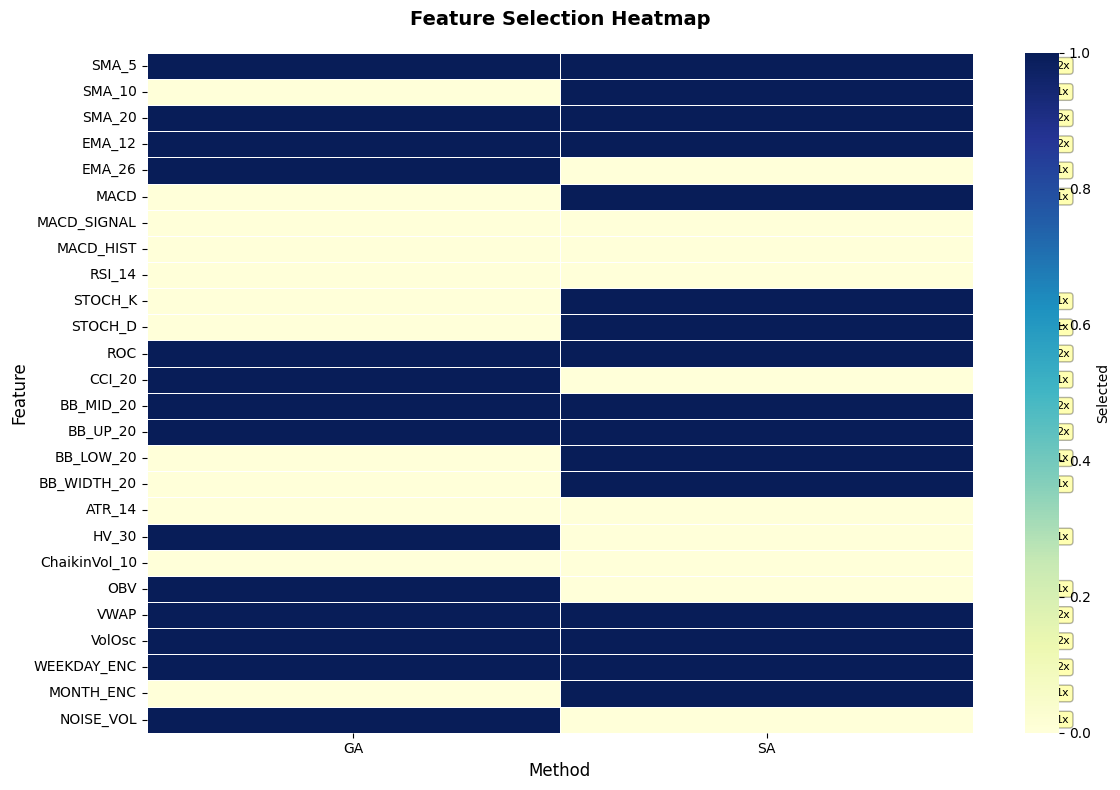

圖3: 特徵選擇熱圖

特徵選擇分析

高共識特徵 (被兩種方法都選中):
  • SMA_5: 2/2 方法選中
  • SMA_20: 2/2 方法選中
  • EMA_12: 2/2 方法選中
  • ROC: 2/2 方法選中
  • BB_MID_20: 2/2 方法選中
  • BB_UP_20: 2/2 方法選中
  • VWAP: 2/2 方法選中
  • VolOsc: 2/2 方法選中
  • WEEKDAY_ENC: 2/2 方法選中

僅被一種方法選中的特徵:
  • SMA_10: 1/2 方法選中
  • EMA_26: 1/2 方法選中
  • MACD: 1/2 方法選中
  • STOCH_K: 1/2 方法選中
  • STOCH_D: 1/2 方法選中
  • CCI_20: 1/2 方法選中
  • BB_LOW_20: 1/2 方法選中
  • BB_WIDTH_20: 1/2 方法選中
  • HV_30: 1/2 方法選中
  • OBV: 1/2 方法選中
  • MONTH_ENC: 1/2 方法選中
  • NOISE_VOL: 1/2 方法選中

從未被選中的特徵（可能是無用特徵）:
  • MACD_SIGNAL: 0/2 方法選中
  • MACD_HIST: 0/2 方法選中
  • RSI_14: 0/2 方法選中
  • ATR_14: 0/2 方法選中
  • ChaikinVol_10: 0/2 方法選中

特徵列表已保存至: ./outputs/selected_features.csv

實驗總結

📊 主要發現:
1. 最佳方法: LSTM-GA
   - RMSE: 39.992653
   - 特徵數: 14
   - 相較Baseline改進: 53.17%

2. GA vs SA比較:
   - GA RMSE: 39.992653
   - SA RMSE: 86.551731
   - GA表現較佳 (優勢: 53.79%)

3. 特徵效率:
   - Baseline特徵數: 26
   - 平均選中特徵數: 15.0
   - 特徵減少: 42.3%

4. 高共識特徵 (兩種方法都選中，推薦用於未來模型):
   1. SMA_5
   2. SMA_20
   3. E

In [9]:
# ============================================================================
# 最終測試集評估
# ============================================================================
print("\n" + "="*80)
print("最終測試集評估")
print("="*80)

def final_evaluation(features, model_class, model_name):
    """
    在測試集上最終評估

    【為什麼需要最終評估？】
    1. 驗證集用於GA/SA選擇特徵
    2. 測試集用於評估真實泛化能力
    3. 避免過擬合驗證集

    【評估流程】
    1. 用選出的特徵重新訓練模型
    2. 在測試集上評估
    3. 報告RMSE和MAE
    """
    print(f"\n🔹 評估 {model_name}...")
    f_idx = [ALL_FEATURES.index(f) for f in features]

    Xtr = X_train_scaled[:, f_idx]
    Xte = X_test_scaled[:, f_idx]

    Xtr_seq, ytr_seq = create_sequences(Xtr, y_train.values, lookback_period)
    Xte_seq, yte_seq = create_sequences(Xte, y_test.values, lookback_period)

    tr_loader = DataLoader(
        TensorDataset(torch.Tensor(Xtr_seq), torch.Tensor(ytr_seq)),
        batch_size=32, shuffle=True
    )
    val_loader = DataLoader(
        TensorDataset(torch.Tensor(Xtr_seq), torch.Tensor(ytr_seq)),
        batch_size=32
    )

    model = model_class(len(features)).to(device)
    model = train_model(model, tr_loader, val_loader, epochs=epochs_final, verbose=True)
    rmse, mae = evaluate_model(model, Xte_seq, yte_seq)

    print(f"{model_name} - RMSE: {rmse:.6f}, MAE: {mae:.6f}")
    return rmse, mae

rmse_ga_trans, mae_ga_trans = final_evaluation(ga_trans_features, LSTMRegressor, "GA-LSTM")
rmse_sa_trans, mae_sa_trans = final_evaluation(sa_trans_features, LSTMRegressor, "SA-LSTM")

# ============================================================================
# [Part 6/6] 結果分析與可視化
# ============================================================================
print("\n" + "="*80)
print("[Part 6/6] 結果分析與可視化")
print("="*80)

results_df = pd.DataFrame({
    'Method': [
        'LSTM-Baseline',
        'LSTM-GA',
        'LSTM-SA'
    ],
    'N_Features': [
        len(ALL_FEATURES),
        len(ga_trans_features),
        len(sa_trans_features)
    ],
    'RMSE': [
        rmse_trans_base,
        rmse_ga_trans,
        rmse_sa_trans
    ],
    'MAE': [
        mae_trans_base,
        mae_ga_trans,
        mae_sa_trans
    ]
})

results_df['RMSE_Improvement'] = (
    (results_df['RMSE'].iloc[0] - results_df['RMSE']) / results_df['RMSE'].iloc[0] * 100
)

print("\n" + "="*80)
print("性能比較結果")
print("="*80)
print(results_df.to_string(index=False))

results_df.to_csv(os.path.join(OUTPUT_DIR, 'results_comparison.csv'), index=False)
print(f"\n結果已保存至: {os.path.join(OUTPUT_DIR, 'results_comparison.csv')}")

# ========================================
# 可視化
# ========================================
print("\n生成可視化圖表...")

# 圖1: 性能對比
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

colors = ['#ff7f0e', '#2ca02c', '#d62728']
x_pos = np.arange(len(results_df))

axes[0].bar(x_pos, results_df['RMSE'], color=colors, alpha=0.8)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(results_df['Method'], rotation=15, ha='right')
axes[0].set_ylabel('RMSE', fontsize=12)
axes[0].set_title('RMSE Comparison', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

for i, v in enumerate(results_df['RMSE']):
    axes[0].text(i, v + 0.5, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

axes[1].bar(x_pos, results_df['N_Features'], color=colors, alpha=0.8)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(results_df['Method'], rotation=15, ha='right')
axes[1].set_ylabel('Number of Features', fontsize=12)
axes[1].set_title('Feature Count Comparison', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

for i, v in enumerate(results_df['N_Features']):
    axes[1].text(i, v + 0.5, f'{int(v)}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, '1_performance_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("圖1: 性能對比柱狀圖")

# 圖2: GA演化過程
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

ax = axes[0, 0]
generations = range(1, len(ga_trans_history['best_scores']) + 1)
ax.plot(generations, ga_trans_history['best_scores'], 'g-o', label='Best', linewidth=2, markersize=6)
ax.plot(generations, ga_trans_history['mean_scores'], 'b--s', label='Mean', linewidth=1.5, markersize=4)
ax.plot(generations, ga_trans_history['worst_scores'], 'r:^', label='Worst', linewidth=1, markersize=4)
ax.set_xlabel('Generation', fontsize=11)
ax.set_ylabel('RMSE', fontsize=11)
ax.set_title('GA Evolution Process', fontsize=13, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
ax.plot(generations, ga_trans_history['best_n_features'], 'go-', linewidth=2, markersize=6)
ax.set_xlabel('Generation', fontsize=11)
ax.set_ylabel('Number of Features', fontsize=11)
ax.set_title('GA: Feature Count Evolution', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

ax = axes[1, 0]
iterations = range(1, len(sa_trans_history['temperatures']) + 1)
ax2 = ax.twinx()
ax.plot(iterations, sa_trans_history['temperatures'], 'r-', label='Temperature', linewidth=2, alpha=0.7)
ax2.plot(iterations, sa_trans_history['current_scores'], 'b--', label='Current RMSE', linewidth=1.5, alpha=0.7)
ax2.plot(iterations, sa_trans_history['best_scores'], 'g-', label='Best RMSE', linewidth=2)
ax.set_xlabel('Iteration', fontsize=11)
ax.set_ylabel('Temperature', fontsize=11, color='r')
ax2.set_ylabel('RMSE', fontsize=11, color='b')
ax.set_title('SA Annealing Process', fontsize=13, fontweight='bold')
ax.tick_params(axis='y', labelcolor='r')
ax2.tick_params(axis='y', labelcolor='b')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
methods = ['GA', 'SA']
rmse_vals = [rmse_ga_trans, rmse_sa_trans]
feat_counts = [len(ga_trans_features), len(sa_trans_features)]
colors_comp = ['#2ca02c', '#d62728']

x = np.arange(len(methods))
width = 0.35

bars1 = ax.bar(x - width/2, rmse_vals, width, label='RMSE', color=colors_comp, alpha=0.8)
ax2 = ax.twinx()
bars2 = ax2.bar(x + width/2, feat_counts, width, label='# Features', color='gray', alpha=0.5)

ax.set_xlabel('Method', fontsize=11)
ax.set_ylabel('RMSE', fontsize=11, color='black')
ax2.set_ylabel('Number of Features', fontsize=11, color='gray')
ax.set_title('GA vs SA: Performance & Feature Count', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, '2_evolution_process.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("圖2: 演化過程分析")

# 圖3: 特徵選擇熱圖
fig, ax = plt.subplots(figsize=(12, max(8, len(ALL_FEATURES) * 0.25)))

feature_matrix = np.zeros((len(ALL_FEATURES), 2))
methods = ['GA', 'SA']
feature_sets = [ga_trans_features, sa_trans_features]

for j, features in enumerate(feature_sets):
    for feat in features:
        i = ALL_FEATURES.index(feat)
        feature_matrix[i, j] = 1

sns.heatmap(feature_matrix,
            xticklabels=methods,
            yticklabels=ALL_FEATURES,
            cmap='YlGnBu',
            cbar_kws={'label': 'Selected'},
            linewidths=0.5,
            linecolor='white',
            ax=ax)

ax.set_title('Feature Selection Heatmap', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Method', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)

selection_counts = feature_matrix.sum(axis=1)
for i, count in enumerate(selection_counts):
    if count > 0:
        ax.text(2.2, i + 0.5, f'{int(count)}x', va='center', fontsize=8,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, '3_feature_selection_heatmap.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("圖3: 特徵選擇熱圖")

# ========================================
# 特徵分析
# ========================================
print("\n" + "="*80)
print("特徵選擇分析")
print("="*80)

feature_consensus = {}
for feat in ALL_FEATURES:
    count = sum([1 for fs in feature_sets if feat in fs])
    if count > 0:
        feature_consensus[feat] = count

feature_consensus = dict(sorted(feature_consensus.items(), key=lambda x: x[1], reverse=True))

print("\n高共識特徵 (被兩種方法都選中):")
high_consensus = {k: v for k, v in feature_consensus.items() if v == 2}
for feat, count in high_consensus.items():
    print(f"  • {feat}: {count}/2 方法選中")

print("\n僅被一種方法選中的特徵:")
mid_consensus = {k: v for k, v in feature_consensus.items() if v == 1}
for feat, count in mid_consensus.items():
    print(f"  • {feat}: {count}/2 方法選中")

print("\n從未被選中的特徵（可能是無用特徵）:")
never_selected = [f for f in ALL_FEATURES if f not in feature_consensus]
for feat in never_selected:
    print(f"  • {feat}: 0/2 方法選中")

feature_lists = pd.DataFrame({
    'GA-LSTM': pd.Series(ga_trans_features),
    'SA-LSTM': pd.Series(sa_trans_features)
})
feature_lists.to_csv(os.path.join(OUTPUT_DIR, 'selected_features.csv'), index=False)
print(f"\n特徵列表已保存至: {os.path.join(OUTPUT_DIR, 'selected_features.csv')}")

# ========================================
# 總結報告
# ========================================
print("\n" + "="*80)
print("實驗總結")
print("="*80)

print("\n📊 主要發現:")
print(f"1. 最佳方法: {results_df.loc[results_df['RMSE'].idxmin(), 'Method']}")
print(f"   - RMSE: {results_df['RMSE'].min():.6f}")
print(f"   - 特徵數: {results_df.loc[results_df['RMSE'].idxmin(), 'N_Features']:.0f}")
print(f"   - 相較Baseline改進: {results_df.loc[results_df['RMSE'].idxmin(), 'RMSE_Improvement']:.2f}%")

ga_rmse = results_df[results_df['Method'].str.contains('GA')]['RMSE'].values[0]
sa_rmse = results_df[results_df['Method'].str.contains('SA')]['RMSE'].values[0]
print(f"\n2. GA vs SA比較:")
print(f"   - GA RMSE: {ga_rmse:.6f}")
print(f"   - SA RMSE: {sa_rmse:.6f}")
if ga_rmse < sa_rmse:
    print(f"   - GA表現較佳 (優勢: {(sa_rmse-ga_rmse)/sa_rmse*100:.2f}%)")
else:
    print(f"   - SA表現較佳 (優勢: {(ga_rmse-sa_rmse)/ga_rmse*100:.2f}%)")

baseline_feats = len(ALL_FEATURES)
avg_selected = results_df.iloc[1:]['N_Features'].mean()
print(f"\n3. 特徵效率:")
print(f"   - Baseline特徵數: {baseline_feats}")
print(f"   - 平均選中特徵數: {avg_selected:.1f}")
print(f"   - 特徵減少: {(1-avg_selected/baseline_feats)*100:.1f}%")

print(f"\n4. 高共識特徵 (兩種方法都選中，推薦用於未來模型):")
for i, (feat, count) in enumerate(list(high_consensus.items())[:15], 1):
    print(f"   {i}. {feat}")

print(f"\n5. 從未被選中的特徵 (可能是無用特徵):")
for i, feat in enumerate(never_selected[:10], 1):
    print(f"   {i}. {feat}")

print("\n" + "="*80)
print("所有結果已保存至:", OUTPUT_DIR)
print("="*80)
print("\n實驗完成！")